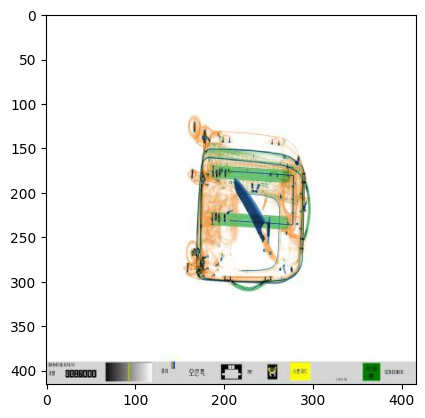

In [1]:
import matplotlib.pyplot as plt
import cv2

# 이미지를 불러옴
image_path = "C:/dataset/knife2.v1i.voc/train/H_8211-91-0000_01_543_png.rf.2dffbff50163c4e91b7f12c7b8874522.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:,:,::-1].copy()

# 이미지를 시각화
plt.imshow(image)
plt.show()

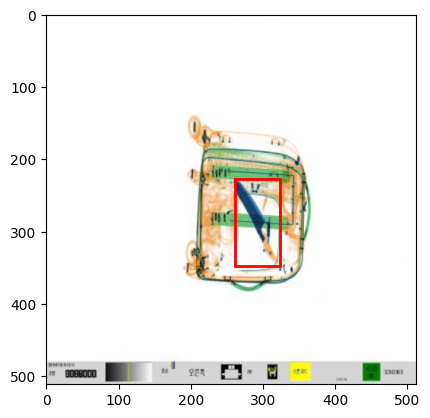

In [2]:
import pandas as pd
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import re
import matplotlib.pyplot as plt

class Data_Structure(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe  # dataframe corresponding to the list of files
        self.image_ids = self.dataframe.index  # Used as ID and index number of each image
        self.class_mapping = {'Knife': 1}  # Add your class mapping here
    
    def __len__(self):  # Method for determining the length of the data set during training
        return len(self.image_ids)  # (ex) len(TRAIN_DATA)
    
    def __getitem__(self, idx):  # Method that returns data when data is indexed
        image_id = self.dataframe.index[idx]  # Input Index = Image ID
        fname = self.dataframe.iloc[idx]['image_path']
        xml = self.dataframe.iloc[idx]['xml_path']
        
        # Images are loaded in BGR channel order, so images are reordered into RGB channels
        image = cv2.imread(fname, cv2.IMREAD_COLOR)[:,:,::-1].copy()
        # Read the XML annotation file and configure it in dictionary format
        tree = ET.parse(xml)
        root = tree.getroot()
        
        # Width and height of image
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        # Get the class name and convert it using the mapping
        object_class_name = root.find('object').find('name').text
        object_class = self.class_mapping.get(object_class_name, 0)  # Default to 0 if not found
        
        # Obtain the 4 coordinates of the object
        bndbox = root.find('object').find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        
        # Convert image to 512x512
        image = cv2.resize(image, (512, 512), cv2.INTER_LINEAR) / 255.
        
        # Bounding box normalization => Adjust coordinates to match resized image
        boxes = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)
        boxes[0,0] = boxes[0,0] / width * 512  # xmin
        boxes[0,1] = boxes[0,1] / height * 512 # ymin
        boxes[0,2] = boxes[0,2] / width * 512  # xmax
        boxes[0,3] = boxes[0,3] / height * 512 # ymax
        
        # Classification
        labels = [object_class]
        
        # Building labeling data for learning
        bbox_w = boxes[0,2] - boxes[0,0]
        bbox_h = boxes[0,3] - boxes[0,1]
        target = {
            'image_id': torch.as_tensor(image_id),
            'boxes': torch.from_numpy(boxes),
            'labels': torch.as_tensor(labels),
            'area'  : torch.as_tensor([bbox_w * bbox_h]),
            'iscrowd': torch.from_numpy(np.zeros(1))
        }
        return (
            torch.from_numpy(image).float().permute(2,0,1),  # After transforming the image into a PyTorch tensor, it is rearranged in the order of channel/horizontal/vertical
            target,
            (boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3])  # Normalized coordinates
        )

# 공통 경로
base_path = r'C:/dataset/knife2.v1i.voc/train/'

# 정규 표현식으로 이미지와 XML 파일 목록 가져오기
image_files = [f for f in os.listdir(base_path) if re.match(r'.*\.jpg$', f)]
xml_files = [f for f in os.listdir(base_path) if re.match(r'.*\.xml$', f)]

# 파일 이름 목록
filenames = [os.path.splitext(f)[0] for f in image_files if os.path.splitext(f)[0] in [os.path.splitext(x)[0] for x in xml_files]]

# 이미지와 XML 파일 경로 생성
image_paths = [os.path.join(base_path, f'{fname}.jpg') for fname in filenames]
xml_paths = [os.path.join(base_path, f'{fname}.xml') for fname in filenames]

# 데이터프레임 생성
data = {
    'image_path': image_paths,
    'xml_path': xml_paths
}

dataframe = pd.DataFrame(data)

# 데이터셋 클래스 초기화
dataset = Data_Structure(dataframe)

# 데이터셋의 첫 번째 항목 불러오기
image, target, (xmin, ymin, xmax, ymax) = dataset[0]

# 이미지 시각화 및 바운딩 박스 그리기
plt.imshow(image.permute(1, 2, 0))  # Convert back to HWC for plotting
plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, edgecolor='red', facecolor='none', linewidth=2))
plt.show()
